In [33]:
'''
This notebook demonstrates two ways to infer the true mean age and true, underlying spread in age of a stellar population
based on observed ages.
'''

from TGAS.mcmc_class import MCMC
import numpy as np
import pandas as pd

class Scaling(MCMC):                                                                                      
    '''
    This class sets up the problem of inferring the intrinsic age distribution, and can be made
    to assume it has a single or two Gaussian components, each with a mean and SD.
    
    The data are asteroseismic ages from K2.
    
    Note that variable names here use mass instead of age, but are actually age!
    '''
    def __init__(self, debug=False, true=False):                                                                      
        '''
        Inputs
        true : bool
         if True, will use the true ages instead of the perturbed
        '''
        # will inherit some attributes/methods from the MCMC class
        super(MCMC, self).__init__()
        
        # number of cores available on your computer
        self.threads = 8
        
        # set up the problem
        self.problem = 'single' # or 'double' --- sets if the age distribution is assumed to be a single or double Gaussian. DOUBLE IS NOT FULLY IMPLEMENTED SEE BELOW.
        self.true = true # if True, then the ages are assumed to have no uncertainty on them.
        self.debug = debug # assume a constant fractional uncertainty 
        self.debug_unc = 0.3 # assumed true, underlying uncertainty in the age distribution for debug case
        self.debug_mass = 9.0 # assumed true ages for debug case --- the data are drawn from the model distribution in this case and you should get 
        # an answer of debug_mass with Sd of self.debug_unc. self.N is the number of fake stars generated, defined below.
        # these should be default be True
        self.compute_mass = True
        self.compute_mass_err = True
        self.compute_c = True

        # set up the data
        self.data = pd.read_csv('/Users/jzinn/warfield/apok2/insideout_scaledage.csv')
        self.data = self.data[~np.isnan(self.data['new_age_e'])] # require uncertainties on the ages
        self.data = self.data.loc[self.data['high_alpha']] # only choose the high-alpha population, which is more reasonably modelled
        # by a Gaussian distribution of ages, compared to the low-alpha population.
        self.N = len(self.data)
        if self.debug:
            self.N = 100 # number of fake stars generated in debug case.
        
        # MCMC parameters
        self.nwalkers = 20                                                                               
        self.nsteps = 3000 #2000                                                                              
        self.rejection_fraction = 0.8                                                                   
        self.burninsteps = 1000 #1000  

    @property                                                                                             
    def guess(self):                                                                                      
        if self.problem == 'single':   
            # one component to the age distribution
            # [age in Gyr, intrinsic spread in age in Gyr]
            self._guess = np.array([9.0, 0.1])   
            self.names = np.array(['mass0', 'masssig0']) # names of the variables that appear in the corner plots
                
        if self.problem == 'double':
            # two components to the age distribution, along with a fraction, f, that describes how many stars
            # are fractionally in one component compared to the other.
            # [age in Gyr, intrinsic spread in age in Gyr]*2
            self._guess = np.array([8.0, 0.1, 9.0, 0.1, 0.1]) 
            self.names = np.array(['mass0', 'masssig0', 'mass1', 'masssig1', 'f']) # names of the variables that appear in the corner plots
        return self._guess                                                                                
                                                                                                          
    @property                                                                                             
    def nvariables(self):                                                                                 
        if self.problem == 'single':                                                                      
            self._nvariables = 2  
            
        if self.problem == 'double':                                                                   
            sself._nvariables = 5  
            
        return self._nvariables   
    
    @nvariables.setter                                                                                    
    def nvariables(self, value):                                                                          
        self._nvariables = value                                                                          
                                                                                                          
    @property                                                                                             
    def true_mass(self):                                                                             
        self._true_mass = np.array([self.debug_mass]*self.N)   

        return self._true_mass 
    
    # this will make sure the uncertainties on the age are calculated.
    # if debug is on, the uncertainty will be a constant fractional uncertainty
    # if debug is off, the uncertainty will be the observed uncertainties
    # if true is on, there will be no uncertainty on the ages
    @property                                                                                             
    def mass_err(self): 
        if self.compute_mass_err:
            
            if self.debug:
                self._mass_err = np.random.choice(self.data['new_age_e'], self.N) # use some of the observed age uncertainties #self.debug_unc #*self.true_mass
            else:
                
                if self.true:
                    self._mass_err = np.array([0.0]*self.N)
                else:
                    self._mass_err = self.data['new_age_e']
                
            self.compute_mass_err = False
            
        return self._mass_err                                                                                               
    
    @property                                                                                             
    def mass(self):
        if self.compute_mass:
            if self.debug:
                self.seed = 1
                np.random.seed(1)
                # assign ages from the assumed underlying distribution of ages
                self._mass = np.random.normal(self.true_mass, self.debug_unc)
                # then add observational uncertainties
                self._mass = np.random.normal(self._mass, self.mass_err)
            else:
                if self.true:
                    self._mass = self.data['new_age']
                else:
                    self._mass = self.data['new_age_pert']      
            self.compute_mass = False
        return self._mass 
                
    # this is the covariance matrix, which is just the addition in quadrature of the SD of the underlying distribution and the
    # uncertainties on the observed ages. Is adjusted for the double case in logl
    def c(self, *args):
        if self.compute_c:
            self._c = self.mass_err**2 + np.array([args[1]**2]*self.N)
     
        return self._c
    
    # require that the SD for the underlying age distribution be positive
    def lnprior(self, *args):   
        if (args[1] < 0):
            return -np.inf
        
        return 0.0
    
    # only set up for a single true age, but the double case is taken care of in logl
    def mass_model(self, *args):
        return args[0]
    
    # optional method to set up data if you wanted to add something here.
    def setup_data(self):
        pass
    
    def logl(self, *args):                                                                                
        '''                                                                                               
        \ln\mathcal{L} for the problem:                                                                   
        \ln\mathcal{L} = -0.5(ageobserved - agemodel)^T C^{-1} (ageobserved - agemodel)    
        In this case, there are no off-diagonal terms in the covariance (all observed ages are assumed to be independent)
        so there are optional simplifications below.
        '''                                                                                               
        
        delta = self.mass - self.mass_model(*args[0])                            
        
        # rescale f to be no greater than 1
        f = args
        
        # if there is a non-diagonal covariance, would need to use this code...
        #cov = self.c(*args[0])                                                                            
        #delta_t = delta.T                                                                                                                                                                    
        #c_inv_delta = np.linalg.lstsq(cov, delta)[0]                                                      
        #_, lndet = np.linalg.slogdet(cov)                                                                 
        # print delta_t.shape, c_inv_delta.shape                                                          
        #self.chi2 = -0.5*np.matmul(delta_t,c_inv_delta) - 0.5*lndet   
        
        # otherwise, right now can just use the diagonal of the covariance matrix
        unc = self.c(*args[0])
        
        # assumes gaussian uncertainties...
        self.chi2 = np.sum(-delta**2/2.0/unc) - 0.5*((np.sum(unc)))
        
        # this is not set up correctly at this point i don't think... I think the f term may need a more subtle treatment than.
        if self.problem == 'double':
            delta = self.mass - self.mass_model(*args[0][2:])  
            unc = self.c(*args[2])
            self.chi2 += np.log((1-args[-1])) + np.log(args[-1])
            self.chi2 += np.sum(-delta**2/2.0/unc) - 0.5*np.sum((unc))
                     
        # add in the prior
        logl = self.chi2 + self.lnprior(*args[0])                                                                 
                                                                                                          
        if np.isnan(logl):                                                                                
            logl = -np.inf  
            
        return logl    
        
def main():                                                                                               
    scaling = Scaling(debug=True)                                                                         
    scaling.run()                                                                                         
                                                                                                          
    params = scaling.samples                                                                              
    params_best = scaling.best_fit  
    # only set up at this point to do print out single model case
    print('best-fitting mass0 : {} +/- {}'.format(params_best[0], scaling.error[0]))                          
    print('best-fitting masssig0 : {} +/- {}'.format(params_best[1], scaling.error[1]))   
    # plotting will work for double, though.
    scaling.plot()  
    
    
# function used for plotting the best-fit distribution(s).                                                                                                     
def gaussian(mass, cen, sig):
    return np.exp(-(mass - cen)**2/2/sig**2)/np.sqrt(2*np.pi*sig**2)

[    0     1     2 ... 11977 11978 11979]
[[8.98567931e+00 2.09086723e-03]
 [8.98567931e+00 2.09086723e-03]
 [8.98567931e+00 2.09086723e-03]
 ...
 [9.10209164e+00 1.34299946e-02]
 [9.09915336e+00 1.09414776e-02]
 [9.09695785e+00 9.34562072e-03]]
False
False
1.589692153601205e-05
1.589692153601205e-05
-25357.36619370675
^^^^
set best_fit to :
[9.06315169 0.01264737]
set error to:
[0.03643269 0.01175806]
1.589692153601205e-05
[    0     1     2 ... 11977 11978 11979]
[[9.64679945 1.17639347]
 [9.64679945 1.17639347]
 [9.64679945 1.17639347]
 ...
 [9.60749305 1.16655305]
 [9.60851108 1.16674472]
 [9.60851108 1.16674472]]
False
False
1.145183345198368
1.145183345198368
-7302.846509255984
^^^^
set best_fit to :
[9.63158023 1.16770904]
set error to:
[0.01575965 0.0066345 ]
1.145183345198368


<Figure size 432x288 with 0 Axes>

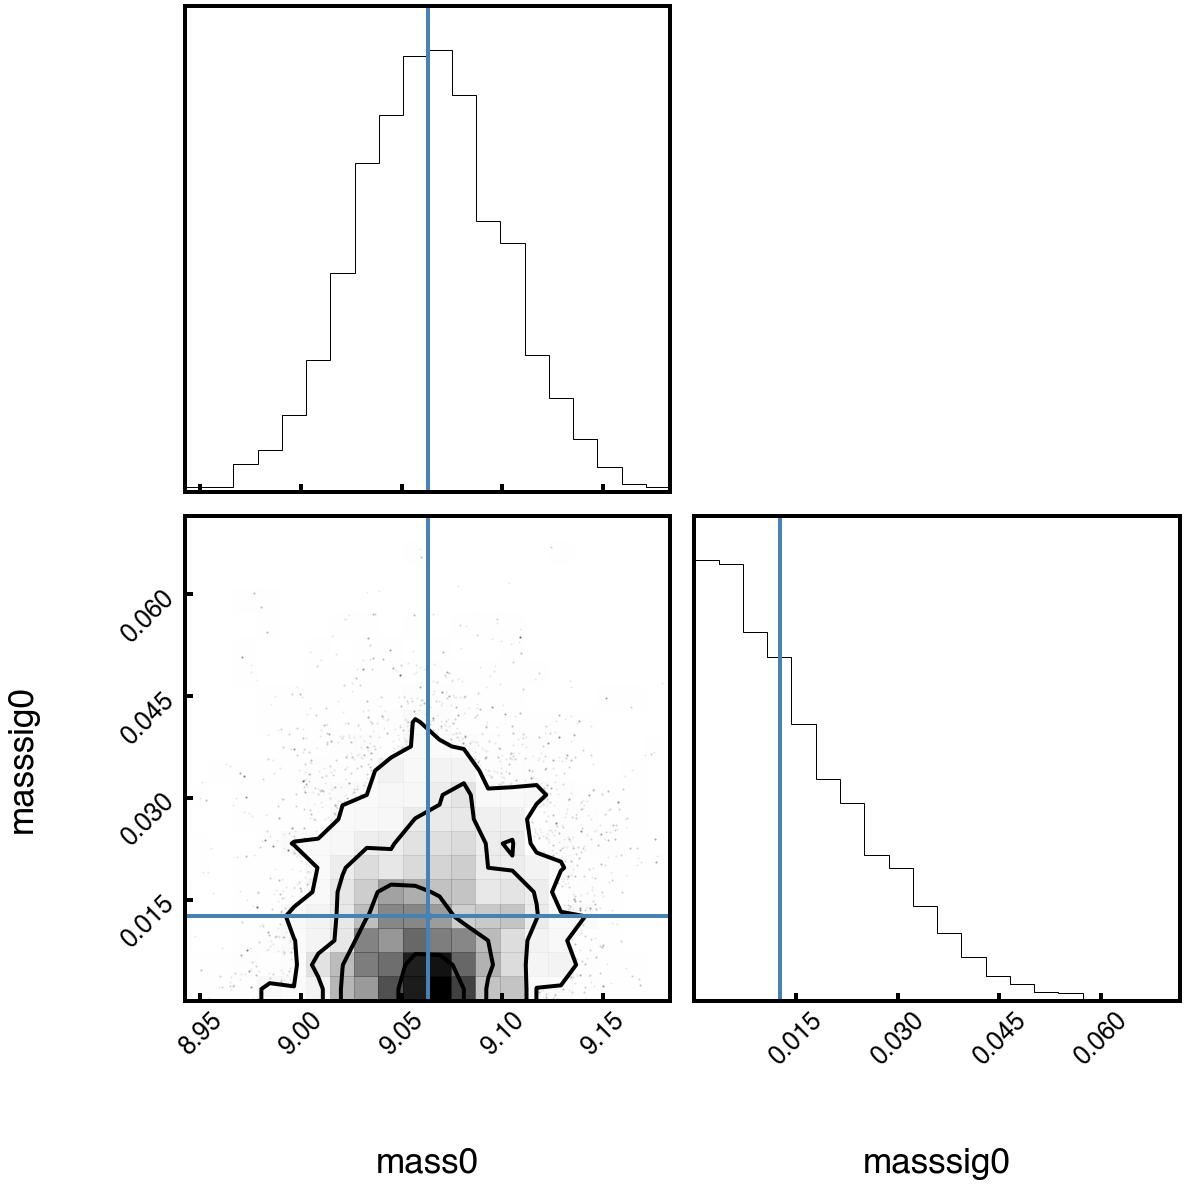

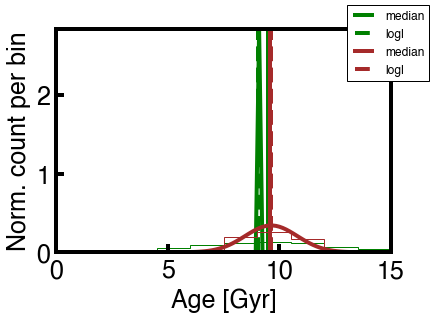

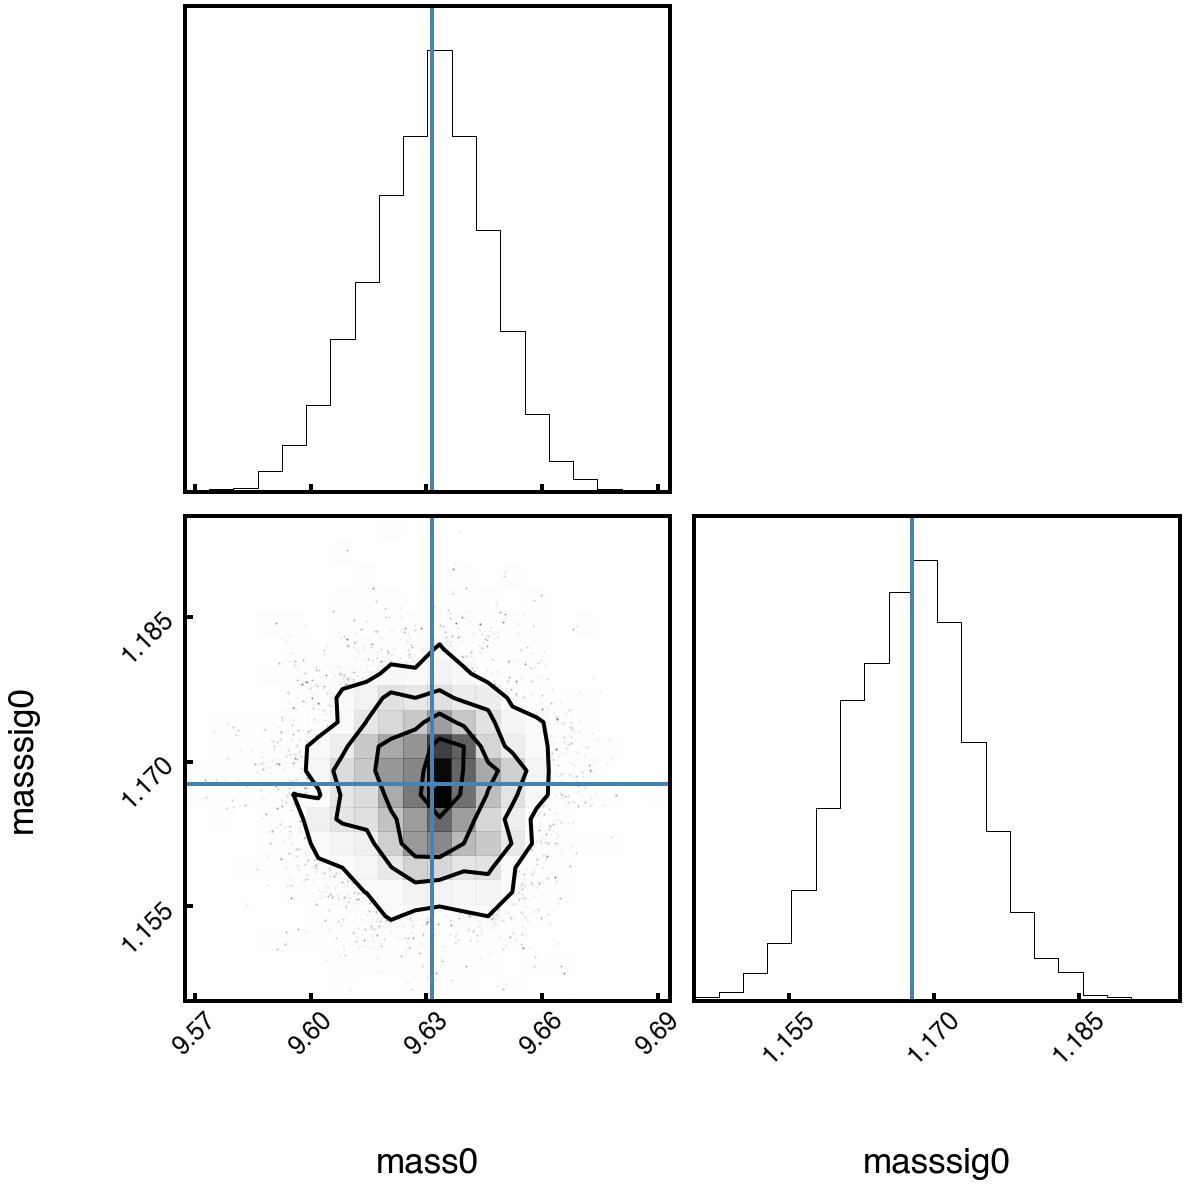

In [24]:
import matplotlib.pyplot as plt
plt.clf()
mass = np.linspace(0,15,100)

%matplotlib inline
scaling = Scaling(debug=False, true=False) 
scaling.run()
scaling.plot()
ax = plt.figure().gca()
ax.hist(scaling.mass, histtype='step', color='green', density=True, range=[0,15])
ax.plot(mass, gaussian(mass, *scaling.best_fit[0:2]), color='green')
med = np.nanmedian(scaling.mass)
ax.axvline(med, label='median', color='green')
med = scaling.best_fit[0]
ax.axvline(med, label='logl', color='green', linestyle='dashed')

scaling = Scaling(debug=False, true=True) 
scaling.run()
scaling.plot()
ax.hist(scaling.mass, histtype='step', color='brown', density=True, range=[0,15])
ax.plot(mass, gaussian(mass, *scaling.best_fit[0:2]), color='brown')
med = np.nanmedian(scaling.mass)
ax.axvline(med, label='median', color='brown')
med = scaling.best_fit[0]
ax.axvline(med, label='logl', color='brown', linestyle='dashed')
ax.set_xlim([0, 15])
ax.figure.legend()
ax.set_xlabel('Age [Gyr]')
ax.set_ylabel('Norm. count per bin')
plt.show()

In [ ]:
# a hierarchical model version of the above using pymc3
# adapted from https://www.pymc.io/projects/examples/en/latest/mixture_models/gaussian_mixture_model.html
import matplotlib.pyplot as plt
import pymc as pm
from xarray_einstats.stats import XrContinuousRV
from scipy.stats import norm
%matplotlib inline
plt.clf()
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})

# use the Scaling class to set up the data

# for testing the model --- should get μ = self.debug_mass and σ = self.debug_unc
scaling = Scaling(debug=True, true=True) 
scaling.mass_err[scaling.mass_err == 0] = 0.0001

# for actually runing th emodel on the data.
#scaling = Scaling(debug=False, true=False) 
print(f"Running on PyMC v{pm.__version__}")

# how many Gaussian components to consider. k = 1 would be the single case from the MCMC code above. k = 2 would be the double case.
k = 1
initval = np.arange(k)+9 # initial guesses for the underlying age distribution means. it is important that they are not equal to each other. must be different! hence linspace instead of
# e.g., initval = [1]*k
# the +9 is to take into account the scale of the observed ages -- -they are around 9 not around 0.

# construct the hierarchical model.
with pm.Model(coords={"cluster": range(k)}) as model:
    # define a distribution from which to draw the means for the Gaussians
    μ = pm.Normal(
        "μ",
        mu=10, # prior on the mean of the means
        sigma=5, # prior on the spread of the means
        transform=pm.distributions.transforms.univariate_ordered,
        initval=initval,
        dims="cluster",
    )
    # now construct distributions to draw the SDs of the Gaussians and the weights (f in the MCMC version)
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster") # σ is drawn from a half-normal distribution (i.e., just defined on the positive reals) with SD 1 (Gyr).
    weights = pm.Dirichlet("w", np.ones(k), dims="cluster") # weights is drawn from a special prior distribution appropriate for describing a prior on weights for distributions
    # for when true=True in Scaling() call...
    #pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=scaling.mass)
    # or for when true = False in Scaling() call...
    
    # what this does is draw fake stars from a combination of k Gaussians, each with means and sigma 
    x = pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, shape=scaling.N)
    
    # and these are the observed data 
    ytrue = pm.Normal('ytrue', mu=x, sigma=scaling.mass_err, observed=scaling.mass)
    
# do the inference.
with model:
    idata = pm.sample(16000, target_accept=0.98) # you may get a warning saying convergence may not have been reached so can increase the number of samples
    # divergences may require a larger target_accept.
import arviz as az

# show the chains of the best-fitting distribution means and SDs.
az.plot_trace(idata, var_names=["μ", "σ"])#, lines=[("μ", {}, [centers]), ("σ", {}, [sds])]);

ax = plt.figure().gca()
# this is the observed age distribution
ax.hist(scaling.mass, histtype='step', color='brown', density=True, range=[0,15])
med = np.nanmedian(scaling.mass)
# and observed median
ax.axvline(med, label='median', color='brown')
ax.set_xlim([0, 15])
ax.figure.legend()
ax.set_xlabel('Age [Gyr]')
ax.set_ylabel('Norm. count per bin')

# draw N fake stars from the best-fitting model distribution
N = 500
xi = np.linspace(1, 15, N)
post = idata.posterior

pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["w"]
print('best-fitting μ: {} +/- {}'.format(np.mean(post["μ"].values), np.std(post["μ"].values)))
print('best-fitting σ: {} +/- {}'.format(np.mean(post["σ"].values), np.std(post["σ"].values)))
az.hdi(idata, hdi_prob=0.95)
y = pdf_components.mean(dim=['chain', 'draw']).sum("cluster")
# plot the mode as a proxy for median. should update this to be the median. it won't matter so much as long as the best-fitting distribution is
# symmetric, which it is by default for k = 1 (a single Gaussian).
mode = y.point[((y)).argmax()]
ax.axvline(mode, label='mode', color='brown', linestyle='dashed')

# this will plot the best-fitting underlying distribution. it should have a smaller spread than 
# the observed distribution, since the observed distribution has observational uncertainties on it.
# you could convolve this distribution with a typical uncertainty in the data and their spreads should agree. should do this!
# but you can test the modelling process by using Scaling(true=True) and setting the uncertainties to a very small number.
pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax, color='green')
plt.show()

Running on PyMC v5.5.0


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, w, x]
INFO:pymc.sampling.mcmc:NUTS: [μ, σ, w, x]


In [27]:
print('best-fitting μ: {} +/- {}'.format(np.mean(post["μ"].values), np.std(post["μ"].values)))
print('best-fitting σ: {} +/- {}'.format(np.mean(post["σ"].values), np.std(post["σ"].values)))

best-fitting μ: 9.629328006291278 +/- 0.01833384453776063
best-fitting σ: 1.362208400648508 +/- 0.01292788684403914
